# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib_venn import venn2, venn3
from scipy.stats import mannwhitneyu
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
from utils import get_brain_expression, get_uniprot, increase_stringency_CSF, keep_first_uniprot, print_p_val

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Brain proteome (HPA)

In [3]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")

## Feature data sets

In [4]:
df_Higginbotham2020 = pd.read_csv(data_path + "/Features/df_features_Higginbotham2020.csv")

## CSF

In [5]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

In [6]:
def get_uniprot_alt(string):
    _, uniprot = string.split("|")
    
    if "-" in uniprot:
        uniprot, _ = uniprot.split("-")

    return uniprot

In [7]:
# import protein lists
Higginbotham2020_brain = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_brain.txt", header=None, 
    names=["Uniprot"])
Higginbotham2020_CSF = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_CSF.txt", 
    header=None, names=["Uniprot"])

In [8]:
# retrieve (parent) Uniprot
Higginbotham2020_brain["Uniprot"] = Higginbotham2020_brain["Uniprot"].apply(get_uniprot_alt)
Higginbotham2020_CSF["Uniprot"] = Higginbotham2020_CSF["Uniprot"].apply(get_uniprot_alt)

## Model and scaler

In [9]:
with open(os.getcwd() + "/Models/LogisticClassifier_L2_1plus.pkl", "rb") as f:  
    L2_CSF1 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_2plus.pkl", "rb") as f:  
    L2_CSF2 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
    L2_CSF3 = pickle.load(f)

In [10]:
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

## Check overlap between brain tissue and CSF

In [11]:
brain_tissue = set(Higginbotham2020_brain["Uniprot"])
only_brain = set(Higginbotham2020_brain["Uniprot"]) - set(Higginbotham2020_CSF["Uniprot"])
brain_to_CSF = set(Higginbotham2020_brain["Uniprot"]).intersection(set(Higginbotham2020_CSF["Uniprot"]))
print("Proteins found in brain tissue:", len(brain_tissue))
print("Proteins only found in brain tissue:", len(only_brain))
print("Proteins found in brain and CSF tissue:", len(brain_to_CSF))

Proteins found in brain tissue: 7960
Proteins only found in brain tissue: 6113
Proteins found in brain and CSF tissue: 1847


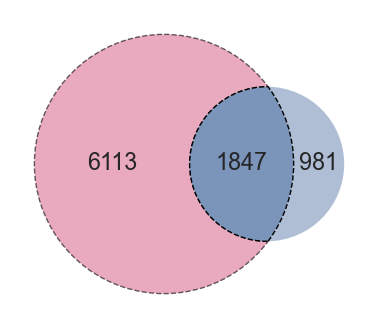

In [12]:
sns.set(style=("ticks"), font_scale=1.4)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

v = venn2([set(Higginbotham2020_brain["Uniprot"]), set(Higginbotham2020_CSF["Uniprot"])], ["", ""], 
    set_colors=("palevioletred", "#7A94BA"), alpha=0.6)
v.get_patch_by_id("11").set_color("#7A94BA")
v.get_patch_by_id("11").set_alpha(1.0)
v.get_patch_by_id("11").set_linestyle("dashed")
v.get_patch_by_id("11").set_edgecolor("black")
v.get_patch_by_id("10").set_linestyle("dashed")
v.get_patch_by_id("10").set_edgecolor("black")
v.get_patch_by_id("10").set_alpha(0.6)
plt.show()

plt.show()
fig.savefig(fig_path + "Venn_brain_tissue_CSF_Higginbotham.png", bbox_inches="tight", dpi=300, transparent=True)

# Prediction

In [13]:
# define variables and target
X = df_Higginbotham2020.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_Higginbotham2020["CSF"]

# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Solubility', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 
        'Sheet_NSP', 'ExpAA', 'First60ExpAA', 'PredHel']

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

In [14]:
df_pred = df_Higginbotham2020.copy()
models = [L2_CSF1, L2_CSF2, L2_CSF3]
model_names = ["L2_CSF1", "L2_CSF2", "L2_CSF3"]

for i, m in enumerate(models):
    # calculate probabilities with trained model
    proba = m.predict_proba(X_scal)
    # create dataframe of probabilities
    proba_df = pd.DataFrame(proba, columns=["non_CSF", "CSF"])
    # add probabilities to main dataframe
    df_pred[model_names[i]] = proba_df["CSF"]

# order dataframe by probabilities and reset index
df_pred.sort_values(by="L2_CSF1", ascending=False, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

df_pred

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00232,PS00237,PS00027,PS00028,PS00022,PS01186,CSF,L2_CSF1,L2_CSF2,L2_CSF3
0,E2RYF7,MPRYVPLLLLLLLLRCSERGGGVNFGEKDAKVPGTWRDGVRVPGEG...,251,26281.8298,0.063745,0.003984,0.123506,0.063745,0.007968,0.095618,...,0,0,0,0,0,0,1,0.998382,0.997882,0.999828
1,P12107,MEPWSSRWKTKRWLWDFTVTTLALTFLFQAREVRGAAPVDVLKALD...,1806,181062.6234,0.054264,0.006091,0.054817,0.068106,0.026024,0.233666,...,0,0,0,0,0,0,1,0.998233,0.999581,0.999462
2,P20908,MDVHTRWKARSALRPGAPLLPPLLLLLLWAPPPSRAAQPADLLKVL...,1838,183557.6216,0.050054,0.006529,0.057127,0.065288,0.021219,0.233406,...,0,0,0,0,0,0,1,0.998045,0.999528,0.999244
3,P02452,MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLR...,1464,138909.8243,0.095628,0.012295,0.045082,0.051230,0.018443,0.267077,...,0,0,0,0,0,0,1,0.998038,0.999652,0.999183
4,P22105,MMPAQYALTSSLVLLVLLSTARAGPFSSRSNVTLPAPRPPPQPGGH...,4244,458383.3197,0.049717,0.028982,0.058435,0.075165,0.026390,0.114279,...,0,0,0,0,1,1,1,0.998003,0.997654,0.994795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8595,Q6ZV89,MQKAGAGGRRASDCGLAPHRPRCITKFAQYVGSFPVDDLDTQESVW...,423,46796.2923,0.087470,0.040189,0.023641,0.068558,0.037825,0.087470,...,0,0,0,0,0,0,-1,0.035576,0.021314,0.008873
8596,Q9NYS7,MEAGEEPLLLAELKPGRPHQFDWKSSCETWSVAFSPDGSWFAWSQG...,404,45285.6443,0.056931,0.032178,0.051980,0.042079,0.042079,0.061881,...,0,0,0,0,0,0,-1,0.034119,0.008944,0.020859
8597,H7C4U4,INEILNIRTKGRTWYILSLTLCRFLAWNYFAHLRLEVLQLTRHPEN...,104,12768.6726,0.038462,0.019231,0.038462,0.038462,0.048077,0.028846,...,0,0,0,0,0,0,-1,0.032125,0.024963,0.027934
8598,Q86T29,MIQSQISFEDVAVDFTLEEWQLLNPTQKNLYRDVMLENYSNLVFLE...,641,74375.4212,0.028081,0.063963,0.020281,0.076443,0.046802,0.068643,...,0,0,0,1,0,0,-1,0.028388,0.019502,0.006939


In [15]:
brain_tissue_proba = df_pred[df_pred["Uniprot"].isin(brain_tissue)]
only_brain_proba = df_pred[df_pred["Uniprot"].isin(only_brain)]
brain_to_CSF_proba = df_pred[df_pred["Uniprot"].isin(brain_to_CSF)]
print("Proteins found in brain tissue in our data set:", len(brain_tissue_proba))
print("Proteins only found in brain tissue in our data set:", len(only_brain_proba))
print("Proteins found in brain and CSF tissue in our data set:", len(brain_to_CSF_proba))

Proteins found in brain tissue in our data set: 7605
Proteins only found in brain tissue in our data set: 5824
Proteins found in brain and CSF tissue in our data set: 1781


In [16]:
additional_brain_to_csf_proteins = set(brain_to_CSF_proba["Uniprot"]) - set(csf["Uniprot"])
print("Novel brain-derived CSF proteins:", len(additional_brain_to_csf_proteins))

Novel brain-derived CSF proteins: 253


In [17]:
sens_CSF1 = len(brain_to_CSF_proba[brain_to_CSF_proba["L2_CSF1"] > 0.5])/len(brain_to_CSF_proba)
print("Correctly predicted CSF proteins (CSF1+):", sens_CSF1)
spec_CSF1 = len(only_brain_proba[only_brain_proba["L2_CSF1"] < 0.5])/len(only_brain_proba)
print("Correctly predicted non-CSF proteins (CSF1+):", spec_CSF1)

sens_CSF2 = len(brain_to_CSF_proba[brain_to_CSF_proba["L2_CSF2"] > 0.5])/len(brain_to_CSF_proba)
print("Correctly predicted CSF proteins (CSF2+):", sens_CSF2)
spec_CSF2 = len(only_brain_proba[only_brain_proba["L2_CSF2"] < 0.5])/len(only_brain_proba)
print("Correctly predicted non-CSF proteins (CSF2+):", spec_CSF2)

sens_CSF3 = len(brain_to_CSF_proba[brain_to_CSF_proba["L2_CSF3"] > 0.5])/len(brain_to_CSF_proba) 
print("Correctly predicted CSF proteins (CSF3+):", sens_CSF3)
spec_CSF3 = len(only_brain_proba[only_brain_proba["L2_CSF3"] < 0.5])/len(only_brain_proba)
print("Correctly predicted non-CSF proteins (CSF3+):", spec_CSF3)

Correctly predicted CSF proteins (CSF1+): 0.7647389107243122
Correctly predicted non-CSF proteins (CSF1+): 0.6605425824175825
Correctly predicted CSF proteins (CSF2+): 0.6934306569343066
Correctly predicted non-CSF proteins (CSF2+): 0.7666552197802198
Correctly predicted CSF proteins (CSF3+): 0.6889387984278496
Correctly predicted non-CSF proteins (CSF3+): 0.7853708791208791


In [18]:
only_brain_proba["Class"] = "non-CSF"
brain_to_CSF_proba["Class"] = "CSF"
combined_pos_neg = pd.concat([only_brain_proba, brain_to_CSF_proba])

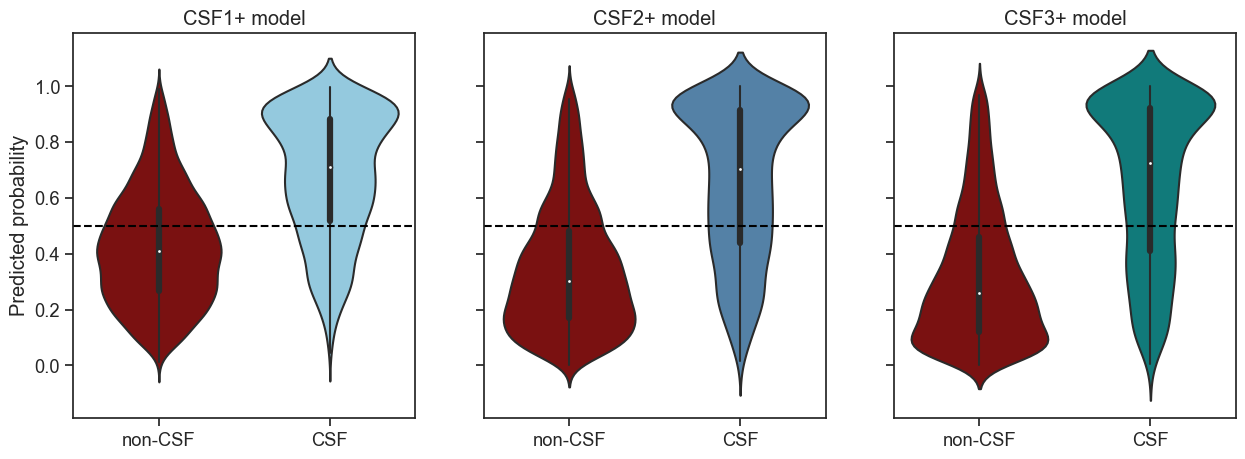

In [19]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)

sns.violinplot(y="L2_CSF1", data=combined_pos_neg, x="Class", orient="v", palette=["darkred", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="CSF1+ model")
ax[0].axhline(y=0.5, color="black", linestyle="--")
sns.violinplot(y="L2_CSF2", data=combined_pos_neg, x="Class", orient="v", palette=["darkred", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="CSF2+ model")
ax[1].axhline(y=0.5, color="black", linestyle="--")
sns.violinplot(y="L2_CSF3", data=combined_pos_neg, x="Class", orient="v", palette=["darkred", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")
ax[2].axhline(y=0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_Higginbotham_violin.png", bbox_inches="tight", dpi=300,
    transparent=True)

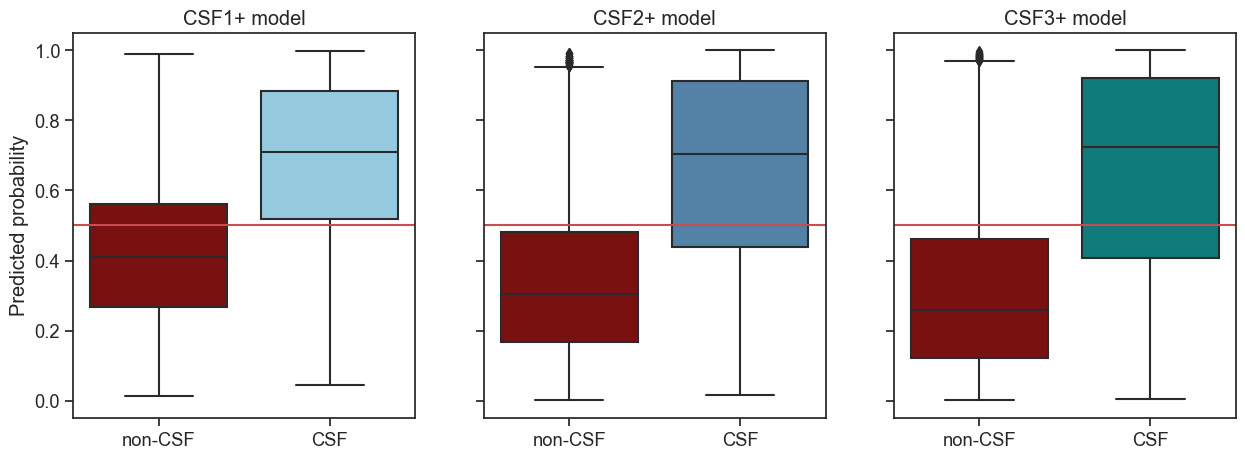

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.boxplot(y="L2_CSF1", data=combined_pos_neg, x="Class", orient="v", palette=["darkred", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="CSF1+ model")
ax[0].axhline(y=0.5, color="r", linestyle="-")
sns.boxplot(y="L2_CSF2", data=combined_pos_neg, x="Class", orient="v", palette=["darkred", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="CSF2+ model")
ax[1].axhline(y=0.5, color="r", linestyle="-")
sns.boxplot(y="L2_CSF3", data=combined_pos_neg, x="Class", orient="v", palette=["darkred", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
fig.savefig(fig_path + "Probability_scores_Higginbotham_box.png", bbox_inches="tight", dpi=300,
    transparent=True)

In [21]:
y_true = np.where(combined_pos_neg["Class"] == "CSF", 1, -1)
y_pred = np.where(combined_pos_neg["L2_CSF1"] > 0.5, 1, -1)
y_pred_CSF2 = np.where(combined_pos_neg["L2_CSF2"] > 0.5, 1, -1)
y_pred_CSF3 = np.where(combined_pos_neg["L2_CSF3"] > 0.5, 1, -1)

print("Balanced accuracy (CSF1+): %.4f" % balanced_accuracy_score(y_true, y_pred))
print("Balanced accuracy (CSF2+): %.4f" % balanced_accuracy_score(y_true, y_pred_CSF2))
print("Balanced accuracy (CSF3+): %.4f" % balanced_accuracy_score(y_true, y_pred_CSF3))

Balanced accuracy (CSF1+): 0.7126
Balanced accuracy (CSF2+): 0.7300
Balanced accuracy (CSF3+): 0.7372


## Comparison of brain expression across prediction groups

In [22]:
# is brain expression lower in false positives compared to true positives?
FP_hi = only_brain_proba[only_brain_proba["L2_CSF3"] > 0.5]
print("Number of false positives:", len(FP_hi))
TP_hi = brain_to_CSF_proba[brain_to_CSF_proba["L2_CSF3"] > 0.5]
print("Number of true positives:", len(TP_hi))
FN_hi = brain_to_CSF_proba[brain_to_CSF_proba["L2_CSF3"] < 0.5]
print("Number of false negatives:", len(FN_hi))
TN_hi = only_brain_proba[only_brain_proba["L2_CSF3"] < 0.5]
print("Number of true negatives:", len(TN_hi))

Number of false positives: 1250
Number of true positives: 1227
Number of false negatives: 554
Number of true negatives: 4574


In [23]:
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]
brain_exp["log2(Brain expression)"] = np.log2(brain_exp["Brain expression"])
brain_exp_CSF = brain_exp.merge(df_pred[["Uniprot", "CSF", "L2_CSF3"]], on="Uniprot", how="inner")
brain_exp_CSF["Score_binary"] = np.where(brain_exp_CSF["L2_CSF3"] > 0.5, 1, -1)

In [24]:
# overlap with expression data
brain_exp_TP_hi = brain_exp.merge(TP_hi[["Uniprot", "L2_CSF3"]], on="Uniprot", how="inner")
brain_exp_TP_hi["Score_binary"] = np.where(brain_exp_TP_hi["L2_CSF3"] > 0.5, 1, -1)
brain_exp_TP_hi["Class"] = "True positives"
brain_exp_FP_hi = brain_exp.merge(FP_hi[["Uniprot", "L2_CSF3"]], on="Uniprot", how="inner")
brain_exp_FP_hi["Score_binary"] = np.where(brain_exp_FP_hi["L2_CSF3"] > 0.5, 1, -1)
brain_exp_FP_hi["Class"] = "False positives"

brain_exp_FP_TP_hi = pd.concat([brain_exp_FP_hi, brain_exp_TP_hi])

Average expression true positives: 6.366
Average expression false positives: 5.599


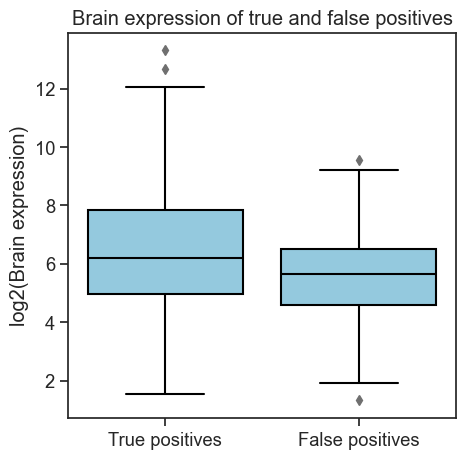

In [25]:
print("Average expression true positives: %.03f"  % np.mean(brain_exp_TP_hi["log2(Brain expression)"]))
print("Average expression false positives: %.03f" % np.mean(brain_exp_FP_hi["log2(Brain expression)"]))

fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

sns.boxplot(y="log2(Brain expression)", data=brain_exp_FP_TP_hi, x="Class", orient="v", palette=["skyblue"], 
    order=["True positives", "False positives"])
ax.set(xlabel=None, title="Brain expression of true and false positives")
plt.setp(ax.artists, edgecolor="black")
plt.setp(ax.lines, color="black")

plt.show()
fig.savefig(fig_path + "Expression_TP_FP_Higginbotham2020.png", bbox_inches="tight", dpi=300,
           transparent=True)